# Box Office Prediction and Analysis

# Introduction

Project Download link : https://s3-us-west-2.amazonaws.com/pdsgroup/PDSgroup.zip (Including all codes, data, results, pictures)

Box office prediction model is as follows:
1. Collect data by crawling website and using api
2. Clean and transform data into structured Pandas dataframes
3. Apply linear regression and decision tree to determine the correlation between movies’ features and box office
4. Generate a model to predict a new movie’s box office based on its characteristics

In [20]:
import csv
import requests
import re
from bs4 import BeautifulSoup
from lxml import etree
import sys
import time

# Part 1 Data Crawling

In this project, we intend to firstly do a box office prediction model and then discover the correlation between movies’ box offices and their characteristics, such as director, producer, actor, genre, country, etc.
We plan to crawler box office data from boxofficemojo.com, which is widely used within the film industry as a source of data and movie information from IMBD via omdb/imdb api.

In [41]:
url = 'http://www.boxofficemojo.com/movies/?id=sahara.htm'
response = requests.get(url)
html = response.text
soup = BeautifulSoup(html, "html.parser")
lxml = etree.HTML(html)

elements = [element for element in lxml.getiterator()]
for element in elements[:10]:
    print(element.tag, '-', element.text)

html - 

head - 

meta - None
title - Sahara (2005) - Box Office Mojo
style - 
table.chart-wide { width: 100%; }

meta - None
meta - None
link - None
link - None
script - None


In [ ]:
def extract_movie_link_by_year(year):
    """ Extract movie:link pair by given year
    """
    #http://www.boxofficemojo.com/yearly/chart/?page=1&view=releasedate&view2=domestic&yr=2017&p=.htm
    movie_link = []
    for i in range(1, 9):
        url = 'http://www.boxofficemojo.com/yearly/chart/?page={0}&view=releasedate&view2=domestic&yr={1}&p=.htm'.format(i, year)
        try:
            response = requests.get(url)
        except Exception as e:
            print ("Exception occurs during extracting movie link, e: ", e)
            return movie_link
            sys.exit(-1)
        if response.status_code != requests.codes.ok:
            print ("response status does not equal 200")
            return movie_link
            sys.exit(-1)
        html = response.text
        #print(html)
        # TODO: 1. Extract movie:link pair from raw html content
        #       2. Filter malformated movie or link
        movie_link.extend(re.findall(herf, html[html.find('<div id="main">'):])[:])
    return movie_link

 We use regular expressions to identify tags and other elements of XML files

In [25]:
# Genre of the movies
genre = re.compile(r'Genre:\s<b>(.*?)</b>')
# Release Date of movies
r_d = re.compile(r'Release Date:\s<b><nobr><a\shref.*?>(.*?)</a>')
# Duration of the movies
runtime = re.compile(r'Runtime:\s<b>(.*?)</b>') 
# Movies' Budget
budget = re.compile(r'Production Budget:\s<b>(.*?)</b>')
# MPAA Rating
MPAARating = re.compile(r'MPAA Rating:\s<b>(.*?)</b>')
# Distributor of the movies
distribute = re.compile(r'Distributor:\s<b>.*?>(.*?)</a>')
# Off screen Date 
c_d = re.compile(r'Close&nbsp;Date:</td>\s*?<td>&nbsp;(.*?)</td>')
# How long for the movie in release
in_release = re.compile(r'<td>In Release:</td>\s*?<td>&nbsp;(.*?)</td>')
# Domestic Box office  
domestic_gross = re.compile(r'<b>Domestic:</b></td>\s*?<td width="35%" align="right">&nbsp;<b>(.*?)</b></td>')
# Worldwide Box office 
world_gross = re.compile(r'<b>Worldwide:</b></td>\s*?<td width="35%" align="right">&nbsp;<b>(.*?)</b></td>')
# Movies Actors, Writer, Director and Producer
player = re.compile(r'<div class="mp_box_tab">The Players</div>\s*?<div class="mp_box_content">\s*?<table>[\S\s]*?</table>')
p_1 = re.compile(r'<tr>(.*?)</tr>')
people = re.compile(r'<a href="/people/chart/.*?>(.*?)</a>')

In [ ]:
def flush_into_file(movie_link, f):
    """Flush movie: link pair to local file
    """
    for link in movie_link:
        f.write("{0}\t{1}\n".format(link[0], link[1]))
    f.flush()
    return f

In [26]:
def GetPeople(movie_link, year):
    Staff = ['Direc', 'Write', 'Actor', 'Produ', 'Cinem', 'Compo']
    with open(movie_link, 'r') as f:
        file = 'movie_people_info_{0}.csv'.format(year)
        num_movies = 0
        with open(file, 'w') as f_people_info:
            headers = '\t'.join(['Movie_Name', 'Genre', 'Release_Date', 'Run_Time', 'Production_Budget', 'MPAA_Rating', 'Distributor', 'Close_Date', 'In_Release', 'Domestic_Gross', 'Worldwide_Gross', 'Director', 'Writer', 'Actor', 'Producer', 'Cinematographer', 'Composer'])
            headers += '\n'
            f_people_info.write(headers)
            for row in f:
                row = row.replace('\n', '')
                num_movies += 1
                if num_movies%5 == 0:
                    time.sleep(1)
                Movie_Info = []
                Movie_Info.append(row.split('\t')[1])
                movie_url = 'http://www.boxofficemojo.com' + row.split('\t')[0]
                try:
                    response = requests.get(movie_url)
                except Exception as e:
                    print ("Exception occurs during extracting movie link, e: ", e, url)
                    continue
                if response.status_code != requests.codes.ok:
                    print ("response status does not equal 200", url)
                    continue
                html = response.text
                #get movie basic information
                #Genre = re.findall(genre, html)[0]
                try:
                    Movie_Info.append(re.findall(genre, html)[0])
                    #Release_Date = re.findall(r_d, html)[0]
                    Movie_Info.append(re.findall(r_d, html)[0])
                    #Run_Time = re.findall(runtime, html)[0]
                    Movie_Info.append(re.findall(runtime, html)[0])
                    #Production_Budget = re.findall(budget, html)[0]
                    Movie_Info.append(re.findall(budget, html)[0])
                    #MPAA_Rating = re.findall(MPAARating, html)[0]
                    Movie_Info.append(re.findall(MPAARating, html)[0])
                    #Distributor = re.findall(distribute, html)[0]
                    Movie_Info.append(re.findall(distribute, html)[0])
                    C = re.findall(c_d, html)
                    Close_Date = 'N/A'
                    if len(C) > 0:
                        Close_Date = C[0]
                    Movie_Info.append(Close_Date)
                    In_Release = 'N/A'
                    if len(re.findall(in_release, html)) > 0:
                        In_Release = re.findall(in_release, html)[0]
                    Movie_Info.append(In_Release)
                    Domestic_Gross = re.findall(domestic_gross, html)[0]
                    Movie_Info.append(Domestic_Gross)
                    Worldwide_Gross = 'N/A'
                    if len(re.findall(world_gross, html)) > 0:
                        Worldwide_Gross = re.findall(world_gross, html)[0]
                    Movie_Info.append(Worldwide_Gross)


            # get movie staff information
                    movie_xml = etree.HTML(html)
                    box = movie_xml.xpath('//div[@class="mp_box_content"]')
                    try:
                        people = box[2]
                        people_list = ','.join(people.itertext('font', 'a', 'br')).split(',')
                        people_list = list(filter((':').__ne__, people_list))
                        people_list = list(filter((' ').__ne__, people_list))
                        people_list = list(filter((lambda x: re.search(r'^(?!\()', x)), people_list))
                    except Exception as e:
                        print('catch exception: ', e)
                        print('box size is: ', len(box))
                        people_list = []
                    ppp = 0
                    names = ''
                    for item in people_list:
                        try:
                            ss = item[:5]
                        except Exception as e:
                            ss = 'aaaaa'
                        if ss not in Staff:
                            if names == '':
                                names = item
                            else:
                                names = names + ','+ item
                        else:
                            if ppp > 0:
                                Movie_Info.append(names)
                            for t in range(Staff.index(ss)-ppp):
                                    Movie_Info.append('N/A')
                            ppp = Staff.index(ss) + 1
                            names = ''
                    if ppp > 0:
                        Movie_Info.append(names)
                    for t in range(6-ppp):
                        Movie_Info.append('N/A')
                    if len(Movie_Info) != 17:
                        print(url, Movie_Info, people_list)
                        raise ValueError('Movie_Info length is not 17!!!')
                except Exception as e:
                    print(movie_url, 'error when parsing this movie. error: ', e)
                mm = '\t'.join(Movie_Info)
                mm += '\n'
                f_people_info.write(mm)
                f_people_info.flush()
        print(num_movies)

Get the CSV file of the Box office information and features

In [28]:
for year in range(2005, 2018):
    movie_link_di = []
    file = 'movie_link_{0}'.format(year)
    f = open(file, 'w')
    movie_link_di = extract_movie_link_by_year(year)
    print(len(movie_link_di))
    f = flush_into_file(movie_link_di, f)
    f.close()

Crawler csv data example

In [29]:
import pandas as pd
df1 = pd.DataFrame.from_csv('movie_info/movie_people_info_2005.csv', sep = '\t')
df1[:10]

,Genre,Release_Date,Run_Time,Production_Budget,MPAA_Rating,Distributor,Close_Date,In_Release,Domestic_Gross,Worldwide_Gross,Director,Writer,Actor,Producer,Cinematographer,Composer
Movie_Name,,,,,,,,,,,,,,,,
Star Wars: Episode III - Revenge of the Sith,Sci-Fi Fantasy,"May 19, 2005",2 hrs. 26 min.,$113 million,PG-13,Fox,"October 20, 2005",155 days / 22.1 weeks,"$380,270,577","$848,754,768",George Lucas,George Lucas,"Anthony Daniels,Christopher Lee,Peter Mayhew*,...","George Lucas,Rick McCallum",David Tattersall,John Williams
"The Chronicles of Narnia: The Lion, the Witch and the Wardrobe",Fantasy,"December 9, 2005",2 hrs. 12 min.,$180 million,PG,Buena Vista,"May 11, 2006",154 days / 22 weeks,"$291,710,957","$745,013,115",Andrew Adamson,"Christopher Markus,Stephen McFeely","Tilda Swinton,James McAvoy,Jim Broadbent*,Liam...",Mark Johnson,Donald McAlpine,Harry Gregson-Williams
Harry Potter and the Goblet of Fire,Fantasy,"November 18, 2005",2 hrs. 33 min.,$150 million,PG-13,Warner Bros.,"April 6, 2006",140 days / 20 weeks,"$290,013,036","$896,911,078",Mike Newell,Steve Kloves,"Warwick Davis,Clemence Poesy,Daniel Radcliffe,...",David Heyman,NaN,"Patrick Doyle,John Williams*"
War of the Worlds,Sci-Fi Horror,"June 29, 2005",1 hrs. 57 min.,$132 million,PG-13,Paramount,"November 22, 2005",149 days / 21.3 weeks,"$234,280,354","$591,745,540",Steven Spielberg,David Koepp,"Amy Ryan*,Tom Cruise,Dakota Fanning,Tim Robbins","Kathleen Kennedy,Paula Wagner,Colin Wilson",Janusz Kaminski,John Williams
King Kong,Period Adventure,"December 14, 2005",3 hrs. 7 min.,$207 million,PG-13,Universal,"April 6, 2006",114 days / 16.3 weeks,"$218,080,025","$550,517,357",Peter Jackson,"Philippa Boyens,Fran Walsh","Naomi Watts,Jack Black,Adrien Brody,Colin Hank...","Peter Jackson,Fran Walsh",Andrew Lesnie,James Newton Howard
Wedding Crashers,Comedy,"July 15, 2005",1 hrs. 53 min.,$40 million,R,New Line,"December 31, 2005",163 days / 23.3 weeks,"$209,255,921","$285,176,741",David Dobkin,NaN,"Owen Wilson,Vince Vaughn,Rachel McAdams,Christ...",Andrew Panay,Julio Macat,Rolfe Kent
Charlie and the Chocolate Factory,Family Adventure,"July 15, 2005",1 hrs. 46 min.,$150 million,PG,Warner Bros.,"December 8, 2005",147 days / 21 weeks,"$206,459,076","$474,968,763",Tim Burton,John August,"Johnny Depp,Freddie Highmore,Helena Bonham Car...",Brad Grey,Philippe Rousselot,Danny Elfman
Batman Begins,Action / Adventure,"June 15, 2005",2 hrs. 20 min.,$150 million,PG-13,Warner Bros.,"October 30, 2005",142 days / 20.3 weeks,"$206,852,432","$374,218,673",Christopher Nolan,"David S. Goyer,Christopher Nolan","Christian Bale,Michael Caine,Liam Neeson,Morga...","Larry J. Franco,Charles Roven,Emma Thomas",Wally Pfister,"James Newton Howard,Hans Zimmer"
Madagascar,Animation,"May 27, 2005",1 hrs. 26 min.,NaN,PG,DreamWorks,"October 13, 2005",NaN,"$193,595,521","$532,680,671","Eric Darnell,Tom McGrath","Eric Darnell,Tom McGrath","Ben Stiller,Chris Rock,David Schwimmer,Jada Pi...",Mireille Soria,NaN,"Harry Gregson-Williams,Hans Zimmer"


# Part 2 Feature Extraction


We decided to use One Hot Encoding to do the feature and lable extraction. One hot encoding transforms categorical features to a format that works better with classification and regression algorithms. As this is ordinal characteristic is usually not desired, one hot encoding is necessary for the proper representation of the distinct elements of the variable. This works very well with most machine learning algorithms. The process of one hot encoding may seem tedious, but fortunately, most modern machine learning libraries can take care of it. The categorical value assignment can be done using sklearn’s LabelEncoder.

In [195]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from collections import Counter

Get a list of Genre Column

In [196]:
def GetGenreList():
    GenreList = set()
    for y in range(2005, 2018):        
        GenreList = GenreList.union(set(pd.DataFrame.from_csv('movie_info/movie_people_info_{0}.csv'.format(y), sep = '\t')['Genre'].tolist()))
    print(GenreList)
    G = set()
    for item in GenreList:
        item = str(item).replace('/', '')
        G = G.union(set(item.split(' ')))
    return GenreList, G

In [197]:
GenresList, G = GetGenreList()
print(G)

{'Action Horror', nan, 'Drama', 'War Romance', 'Sci-Fi Comedy', 'Action / Crime', 'Fantasy', 'Sci-Fi', 'Sports Drama', 'Action Drama', 'Period Action', 'Family', 'Fantasy Drama', 'Historical Drama', 'Musical', 'Crime Comedy', 'Romance', 'Adventure', 'Comedy Thriller', 'Action', 'Romantic Adventure', 'Documentary', 'Sports Action', 'Crime Drama', 'Unknown', 'Period Adventure', 'Western Comedy', 'Western', 'Sci-Fi Action', 'Sci-Fi Adventure', 'Horror Comedy', 'Family Comedy', 'Comedy / Drama', 'Crime Thriller', 'Fantasy Comedy', 'Drama / Thriller', 'Horror Thriller', 'Sci-Fi Horror', 'Romantic Comedy', 'Family Adventure', 'Foreign', 'Adventure Comedy', 'War Drama', 'Foreign / Horror', 'War', 'Sports', 'Action Comedy', 'Comedy', 'Romantic Thriller', 'IMAX', 'Horror', 'Action / Adventure', 'Concert', 'Historical Epic', 'Period Comedy', 'Action Thriller', 'Foreign / Action', 'Crime', 'Period Drama', 'Action Fantasy', 'Thriller', 'Sci-Fi Fantasy', 'Sci-Fi Thriller', 'Animation', 'Music Drama

Counter of the BudgetList

In [168]:
def AllCounter(col_key):
    """
    return a counter
    """
    BudgetList = []
    for y in range(2005, 2018):
        BudgetList += pd.DataFrame.from_csv('movie_info/movie_people_info_{0}.csv'.format(y), sep = '\t')[col_key].tolist()
    # print(BudgetList)
    return Counter(BudgetList)

Got total 725 Distributor but just picked the top 100 Distributor. The rest we thought it won't affect too much on the box office. Then, we make a count for them.

In [169]:
c = Alllist('Distributor')
print(len(c))
c.most_common(100)

725


[('IFC', 390),
 ('Magnolia', 313),
 ('Warner Bros.', 253),
 ('Sony Classics', 228),
 ('Universal', 217),
 ('Fox', 215),
 ('First Run', 178),
 ('Buena Vista', 176),
 ('Sony / Columbia', 175),
 ('Strand', 172),
 ('Lionsgate', 166),
 ('Eros', 148),
 ('Kino Lorber', 145),
 ('Paramount', 138),
 ('Roadside Attractions', 112),
 ('Weinstein Company', 110),
 ('Fox Searchlight', 110),
 ('Indican', 107),
 ('Focus Features', 100),
 ('Freestyle Releasing', 97),
 ('UTV Communications', 93),
 ('Music Box Films', 91),
 ('Film Movement', 83),
 ('China Lion', 79),
 ('Oscilloscope Pictures', 78),
 ('Rialto', 74),
 ('Samuel Goldwyn', 74),
 ('Well Go USA', 73),
 ('Regent Releasing', 71),
 ('Monterey Media, Inc.', 68),
 ('ThinkFilm', 67),
 ('Cohen Media Group', 67),
 ('Zeitgeist', 66),
 ('Cinema Guild', 61),
 ('Abramorama', 59),
 ('Anchor Bay Films', 58),
 ('Sony / Screen Gems', 57),
 ('A24', 57),
 ('Warner Bros. (New Line)', 55),
 ('Kino', 51),
 ('CJ Entertainment', 51),
 ('Variance Films', 50),
 ('Miramax

A help function. no using in data processing

In [123]:
# help function. no using in data processing
def GetAll(col_key):
    """
    return a set
    """
    DistributorList = set()
    for y in range(2005, 2018):
        DistributorList = DistributorList.union(set(pd.DataFrame.from_csv('movie_info/movie_people_info_{0}.csv'.format(y), sep = '\t')[col_key].tolist()))
    #print(DistributorList)
    return DistributorList

Creat the genre labels 

In [170]:
def CreatGenreLabels(G, data):
    """
    input:  G: unique set of Genres type, including nan;
            data: pandas dataframe
    output: pandas dataframe with one/more hot encoding of genres type
    """
    genres = data['Genre'].apply(str)
    g = {}
    for i in G:
        g[i] = []
    for s in genres:
        s = str(s).replace('/', '')
        for item in s.split(' '):
            g[item].append(1)
        for item in G.difference(set(s.split(' '))):
            g[item].append(0)
    try:
        del g['']
        del g['nan']
        g['Romance'] = [a or b for a,b in zip(g['Romance'], g['Romantic'])]
        del g['Romantic']
        g['Music'] = [a or b for a,b in zip(g['Music'], g['Musical'])]
        del g['Musical']
        data = data.drop('Genre', 1)
        for k,v in g.items():
            data['Genre_' + k] = pd.Series(v, index = data.index)
    except Exception as e:
        print('Something wrong with my code: ', e)
    return data
    

Now we can begin to create features

In [171]:
# fisrt part of data processing, second part is in dp.ipynb
def CreateFeatures(data):
    # production budget string to number/10,000, if NaN, set as 0
    budget = data['Production_Budget'].apply(str)
    num_budget = []
    for s in budget:  
        if s[-4:] == 'lion':
            num_budget.append(float(s[1:-8])*100)
        else:
            try:
                num_budget.append(int(s.replace('$', '').replace(',', ''))/10000)
            except Exception as e:
                # print('catch exception in budget processing', s)
                num_budget.append(0)
    data['Product_Budget'] = pd.Series(num_budget, index = data.index)
    data = data.drop('Production_Budget', 1)
    
    # release date to datetime format
    try:
        data['DateofRelease'] = pd.to_datetime(data['Release_Date'].apply(str), format = '%B %d, %Y')
    except Exception as e:
        print('catch exception in date of release processing: ', e, s)
            
        
    
    
    # run_time to number of minutes, if nan set as 90 mins
    rt = []
    for s in data['Run_Time'].apply(str):
        if 'hrs' in s:
            rt.append(int(s.split(' hrs. ')[0]) * 60 + int(s.split(' hrs.')[1].split(' min.')[0]))
        else:
            rt.append(90)
    data['Runtime_minnutes'] = pd.Series(rt, index = data.index)
    
    # MPAA_Rating to one hot encoding: R, PG13, NC17, PG, G, unrating
    MPAA_Rating = []
    ratings = ['nan', 'Unknown', 'Not Yet Rated', 'Unrated']
    for s in data['MPAA_Rating'].apply(str):
        if s in ratings:
            MPAA_Rating.append('MPAA_unrated')
        else:
            MPAA_Rating.append('MPAA_' + s)
    data['MRating'] = pd.Series(MPAA_Rating, index = data.index)
    
    d = data['MRating'].str.get_dummies()    
    data = pd.concat([data, d], axis=1)
    try:
        data = data.drop(['MPAA_Rating'], axis=1)
        data = data.drop(['MRating'], axis=1)
        data = data.drop('Release_Date', axis = 1)
        data = data.drop('Run_Time', axis = 1)
    except Exception as e:
        print('drop exception caught: ', e)
    return data
    
    
    
        
            
    
    

Create labels

In [177]:
def CreatLabels(data):
    """
    input: data: a pandas dataframe
    output: a pandas dataframe, with a col of DoGross_GT = domestic gross/10000, a col of domestic DoGross_Magnitude
    """
    dg = data['Domestic_Gross'].apply(str)
    DoGross_Magnitude = []
    DoGross_GT = []
    for s in dg:
        try:
            values = s.replace(',', '').replace('$', '')
            DoGross_GT.append(float(values)/10000)
            DoGross_Magnitude.append(len(values))
        except Exception as e:
            DoGross_GT.append(np.nan)
            DoGross_Magnitude.append(np.nan)
            print('Exception caught when processing Domestic Gross as e: ', w)
    data['DoGross_Magnitude'] = pd.Series(DoGross_Magnitude, index = data.index)
    data['DoGross_GT'] = pd.Series(DoGross_GT, index = data.index)
    data = data[pd.notnull(data['DoGross_GT'])]
    data = data.drop('Domestic_Gross', axis = 1)
    return data
    

Processing the crawler csv data (2005-2018 movies information)

In [186]:
def processing_pipeline():
    for y in range(2005, 2018):        
        data = pd.DataFrame.from_csv('movie_info/movie_people_info_{0}.csv'.format(y), sep = '\t')
        data = CreatGenreLabels(G, CreatLabels(CreateFeatures(data)))
        data.to_csv('data_processing/movie_processing1_{0}.csv'.format(y), sep = '\t')
    print('data processing pipeline finish~ ^ ^')

In [194]:
processing_pipeline()

data processing pipeline finish~ ^ ^


After a simple analyse, we found one dirty data in 2011 movie data. Thus, we deleted it.

In [193]:
# one dirty data in 2011 movie data, deleting it
MovieData2011 = pd.DataFrame.from_csv('movie_info/movie_people_info_2011.csv', sep = '\t')
print(len(MovieData2011))
MovieData2011 = MovieData2011.drop(['Frankie &amp; Alice'])
print(len(MovieData2011))
MovieData2011.to_csv('movie_info/movie_people_info_2011_1.csv', sep = '\t')

602
601


In [163]:
c = Counter(MovieData2005['Distributor'].tolist())
c.most_common(100)

[('Sony Classics', 23),
 ('Warner Bros.', 19),
 ('Universal', 19),
 ('Fox', 18),
 ('Lions Gate', 18),
 ('Buena Vista', 17),
 ('ThinkFilm', 15),
 ('Sony / Columbia', 14),
 ('Miramax', 14),
 ('Eros', 13),
 ('Paramount', 12),
 ('IFC', 12),
 ('First Run', 11),
 ('New Line', 10),
 ('Wellspring', 10),
 ('Strand', 10),
 ('Indican', 10),
 ('DreamWorks', 9),
 ('IDP', 9),
 ('Kino', 9),
 ('MGM', 8),
 ('Magnolia', 8),
 ('Tartan', 8),
 ('Focus Features', 7),
 ('Palm', 7),
 ('New Yorker', 7),
 ('TLA Releasing', 7),
 ('Warner Independent', 6),
 ('Dimension Films', 6),
 ('Weinstein Company', 6),
 ('Fox Searchlight', 6),
 ('Paramount Classics', 6),
 ('Vitagraph', 6),
 ('Freestyle Releasing', 6),
 ('Regent Releasing', 6),
 ('Picture This!', 6),
 ('Castle Hill', 6),
 ('Newmarket', 5),
 ('Shadow Dist.', 5),
 ('Yash Raj', 5),
 ('Slowhand Cinema', 5),
 ('Zeitgeist', 5),
 ('UTV Communications', 5),
 ('First Look', 5),
 ('Sony (Revolution)', 4),
 ('Sony / Screen Gems', 4),
 ('Picturehouse', 4),
 ('Rialto', 4)

After creating, preprocessing and simple analysing those features, we begin to do the feature extraction.

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import time
import multiprocessing
import string

In [2]:
# import glob
import operator
import itertools
import collections

Firstly, we called when each worker is initialized, it sets the context which will be shared across all mappers.

Then, we did a mapreduce job. We initialized a Map Reduce Job with the map, reduce functions, number of worker threads and the shared context across mappers.

Afterwards, we odrganized the mapped values by their key.

Finally, we processed the inputs through the map and reduce functions given


In [3]:
# Copyright (c) 2016 All rights reserved.

# Redistribution and use in source and binary forms, with or without modification,
# are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
# list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
# this list of conditions and the following disclaimer in the documentation and/or
# other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its contributors
# may be used to endorse or promote products derived from this software without
# specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
# ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
# ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

def init_worker_context(context_to_set):
    """Called when each worker is initialized, it sets the context which will be shared across all
    mappers.
    """
    global context
    # context can be accessed from the mapper function of every worker
    context = context_to_set

class MapReduceJob(object):
    
    def __init__(self, map_func, reduce_func, num_workers=None, worker_context=None):
        """ Initialize a Map Reduce Job with the map, reduce functions, number of worker threads and the shared context
        across mappers.
        Args:
            map_func:     function to map inputs to intermediate data. Takes as argument one input value and 
                            returns a tuple with the key and a value to be reduced.
            reduce_func:  function to reduce partitioned version of intermediate data to final output. Takes as
                            argument a key as produced by map_func and a list of the values associated with that key.
            num_workers:  int, the number of workers to create in the pool. Defaults to #CPUs on the current host.
            context:      any application-specific type, stores data that should be read-accessible from all workers
                            but it should NOT be written while the MR job is in progress.
        Attributes to set:
            map_func:     function to map inputs to intermediate data. (same description as above)
            reduce_func:  function to reduce intermediate data to final output. (same description as above)
            pool:         multiprocessing.Pool object, with num_workers worker threads. The threads should initialize
                            the worker context passed before running any map jobs.
                            (See init_worker_context function above.)
        """
        self.map_func = map_func
        self.reduce_func = reduce_func
        if worker_context is not None:
            self.pool = multiprocessing.Pool(num_workers, initializer=init_worker_context, initargs=(worker_context,))
        else:
            self.pool = multiprocessing.Pool(num_workers)
    
    def partition(self, mapped_values):
        """Organize the mapped values by their key.
        Args:
            mapped_values: output key-value pairs from mappers
        Outputs:
            list:          returns an unsorted sequence of tuples with a key and a sequence of values.
        """
        partitioned_data = collections.defaultdict(list)
        for key, value in mapped_values:
            partitioned_data[key].append(value)
        return partitioned_data.items()

    def __call__(self, inputs, chunksize=1):
        """Process the inputs through the map and reduce functions given.
        Args:
            inputs:       (array-like) contains the input data to be processed.
            chunksize=1 : the portion of the input data to hand to each worker; can be used to tune performance 
                            during the mapping phase.
        Outputs:
            reduced_values: list of outputs from reduce functions.
        """
        # partition inputs according to chunksize
        indices = list(range(0, len(inputs), chunksize))
        if indices[-1] != len(inputs):
            indices.append(len(inputs))
        inputs_split = [inputs[start:end] for start, end in zip(indices[:-1], indices[1:])]
        # map
        map_responses = self.pool.map(self.map_func, inputs_split)
        # partition by key
        partitioned_data = self.partition(itertools.chain(*map_responses))
        # reduce
        reduced_values = self.pool.map(self.reduce_func, partitioned_data)
        return reduced_values

We analyse the holiday time affect to the box office. (Picked up the holiday time features)
we used those holidays as the label/feature:

New Year's Day,

Martin Luther King, Jr,

Independence Day, 

Memorial Day,

Thanksgiving Day,




In [4]:
import datetime

def is_holiday(date):
    date = pd.to_datetime(date)
    if date.month == 1 and (date.day in range(1, 4) or date.day in range(8, 16)):
        return True
    if date.month == 2 and date.day in range(7, 15):
        return True
    if date.month == 7 and date.day in range(5):
        return True
    if date.month == 6 and date.day in range(28, 31):
        return True
    if date.month == 11 and date.day in range(15, 26):
        return True
    if date.month == 12 and date.day in range(13, 32):
        return True
    return False

def RDtoHoliday(data):
    holiday = []
    for release_date in pd.to_datetime(data['DateofRelease']):
        try:
            holiday.append(int(is_holiday(release_date)))
        except Exception as e:
            print('maybe nan here in release date: ', e, release_date)
            holiday.append(0)
    data['Is_Holiday'] = pd.Series(holiday, index = data.index)
    data = data.drop(['DateofRelease'], axis=1)
    print(data['Is_Holiday'][:10])
    return data

Actors information map with box offices

In [5]:
def map_to_box_office(data):
    output = []
    for actors, box_office in zip(data[context], data['DoGross_GT']):
        # box_office_num = int(box_office.replace('$', '').replace(',', ''))
        for actor in actors.split(','):
            output.append((actor.strip(), box_office))
    return output

def reduce_to_box_office(item):
    actor, box_office = item
    return (actor, sum(box_office)/len(box_office))

# actor_to_box_office_job = MapReduceJob(map_actor_to_box_office, reduce_actor_to_box_office, num_workers=2, worker_context = )
# actor_ranks = actor_to_box_office_job(all_movies[pd.notnull(all_movies['Actor'])], chunksize=1)
# actor_ranks.sort(key=operator.itemgetter(1), reverse=True)
# top_actors = {actor:box_office for actor, box_office in actor_ranks[1:101]}
# for key, value in sorted(top_actors) top_actors.sort(key=lambda x: )

Map data using One hot Encoder

In [9]:
def MapReduce_OneHot(data, col_key, colnum):
    """
    input:  data: dataframe, pd.dataframe
            col_key: col key to processing, str
    output: processed dataframe
    """
    col_to_box_office_job = MapReduceJob(map_to_box_office, reduce_to_box_office, num_workers=2, worker_context = col_key)
    actor_ranks = col_to_box_office_job(data[pd.notnull(data[col_key])], chunksize=1)
    actor_ranks.sort(key=operator.itemgetter(1), reverse=True)
    print(type(actor_ranks), len(actor_ranks))
    try:
        selected = actor_ranks[:colnum]
    except Exception as e:
        selected = actor_ranks
        print('caught exception when [:?]', e, len(actor_ranks))

    # one hot encoding for actors with top 200 box office
    oh = {}
    for a,g in selected:
        oh[a] = []
    for A in data[col_key].apply(str):
        for k,v in oh.items():
            oh[k].append(0)
        try:
            for s in A.split(','):
                s = s.strip()
                if s in oh:
                    oh[s][-1] = 1
        except Exception as e:
            print('caught exception here: ', A)
    for k, v in oh.items():
        data[col_key + '_' + k.replace(' ', '_')] = pd.Series(v, index = data.index)
    data = data.drop([col_key], axis=1)    
    return data
    

In [10]:
# final feature from data processing
all_movies = pd.concat([pd.read_csv('data_processing/movie_processing1_{0}.csv'.format(y), sep = '\t') for y in range(2005, 2018)])


3861


In [ ]:
# final feature from data processing
all_movies = all_movies[pd.notnull(all_movies['Actor'])]
all_movies = all_movies.set_index('Movie_Name')
print(len(all_movies))
a = RDtoHoliday(all_movies)
a = MapReduce_OneHot(a, 'Actor', 50)
a = MapReduce_OneHot(a, 'Director', 50)
a = MapReduce_OneHot(a, 'Composer', 30)
a = MapReduce_OneHot(a, 'Cinematographer', 30)
a = MapReduce_OneHot(a, 'Distributor', 30)
a = MapReduce_OneHot(a, 'Writer', 30)
a = MapReduce_OneHot(a, 'Producer', 30)
a = a.drop(['Close_Date'], axis=1)
a.to_csv('5030mapreduce_onehot_all.csv', sep = '\t')
a[:5]

# Add one more feature

We crawlered and added another feature ( Theaters numbers of the movies). We wanted to figure out whether this feature affect to the box office

In [1]:
import csv
import requests
import re
from bs4 import BeautifulSoup
from lxml import etree
import sys
import time

In [2]:
url = 'http://www.boxofficemojo.com/movies/?id=sahara.htm'
url1 = 'http://www.boxofficemojo.com/movies/?id=strangerswithcandy.htm'
response = requests.get(url)
html = response.text
response1 = requests.get(url1)
html1 = response1.text

In [18]:
movie_xml = etree.HTML(html)
movie_xml1 = etree.HTML(html1)
try:
    box = movie_xml.xpath('//div[@class="mp_box_content"]')[1]
    box1 = movie_xml1.xpath('//div[@class="mp_box_content"]')[1]
except Exception as e:
    print('catch exception when extracting box content: ', e)
print(etree.tostring(box, pretty_print = True))
for s in '+'.join(box.itertext('table', 'tr', 'td')).split('+'):
    if 'theaters' in s:
        print(s.strip())

for s in '+'.join(box1.itertext('table', 'tr', 'td')).split('+'):
    if 'theaters' in s:
        print(s.strip())
        


b'<div class="mp_box_content">\n\t\n\t\t<table border="0" cellspacing="0" cellpadding="0">\n\t\t<tr>\n\t\t\t<td align="center"><a href="/weekend/chart/?yr=2005&amp;wknd=14&amp;p=.htm">Opening&#160;Weekend:</a></td><td>&#160;$18,068,372</td></tr>\n\t\t<tr>\n\t\t\t<td align="center" colspan="2"><font size="2">(#1 rank, 3,154 theaters, $5,729 average)</font></td></tr>\n\t\t<tr>\n\t\t\t<td align="right">%&#160;of&#160;Total&#160;Gross:</td><td>&#160;26.3%</td></tr>\n\t\t<tr><td align="right" colspan="2"><font face="Helvetica, Arial, Sans-Serif" size="1"><a href="/movies/?page=weekend&amp;id=sahara.htm"><b>&gt; View All 17 Weekends</b></a></font></td></tr>\n\n\t\t</table>\n\n\n\n\t\t<table border="0" cellspacing="0" cellpadding="0">\n\t\t<tr>\n\t\t\t<td>Widest&#160;Release:</td>\n\t\t\t<td>&#160;3,200 theaters</td>\n\t\t</tr>\n\t\t</table>\n\n\n\t\t<table border="0" cellspacing="0" cellpadding="0">\n\t\t<tr>\n\t\t\t<td>Close&#160;Date:</td>\n\t\t\t<td>&#160;August 4, 2005</td>\n\t\t</tr>\n\

In [19]:
def flush_into_file(movie_link, f):
    """Flush movie:link pair to local file
    """
    for link in movie_link:
        f.write("{0}\t{1}\n".format(link[0], link[1]))
    f.flush()
    return f

In [32]:
def GetTheaters(movie_link, year):
    with open(movie_link, 'r') as f:
        file = 'movie_theaters_{0}.csv'.format(year)
        num_movies = 0
        with open(file, 'w') as f_people_info:
            headers = '\t'.join(['Movie_Name', 'Theaters_Num'])
            headers += '\n'
            f_people_info.write(headers)
            for row in f:
                row = row.replace('\n', '')
                num_movies += 1
                if num_movies%20 == 0:
                    time.sleep(1)
                Movie_Info = []
                Movie_Info.append(row.split('\t')[1])
                movie_url = 'http://www.boxofficemojo.com' + row.split('\t')[0]
                try:
                    response = requests.get(movie_url)
                except Exception as e:
                    print ("Exception occurs during extracting movie link, e: ", e, url)
                    continue
                if response.status_code != requests.codes.ok:
                    print ("response status does not equal 200", url)
                    continue
                html = response.text
                try:
                    movie_xml = etree.HTML(html)
                    box = movie_xml.xpath('//div[@class="mp_box_content"]')[1]
                except Exception as e:
                    print('catch exception when xpathing mpboccontent as e', e)
                    continue
                s = '+'.join(box.itertext('table', 'tr', 'td'))
                if 'theaters' in s:
                    for ll in s.split('+'):
                        if 'theaters' in ll:
                            # print(ll)
                            Movie_Info.append(ll.strip().replace(' theaters', '').replace(',', ''))
                else:
                    Movie_Info.append('NaN')
                mm = '\t'.join(Movie_Info)
                mm += '\n'
                f_people_info.write(mm)
                f_people_info.flush()
        print(num_movies)
                
                    
                

In [33]:
for y in range(2006, 2018):
    moviel_url = 'movie_link_{0}'.format(y)
    GetTheaters(moviel_url, y)

608
631
607
521
537
602
669
catch exception when xpathing mpboccontent as e list index out of range
catch exception when xpathing mpboccontent as e list index out of range
catch exception when xpathing mpboccontent as e list index out of range
catch exception when xpathing mpboccontent as e list index out of range
catch exception when xpathing mpboccontent as e list index out of range
catch exception when xpathing mpboccontent as e list index out of range
688
catch exception when xpathing mpboccontent as e list index out of range
706
catch exception when xpathing mpboccontent as e list index out of range
catch exception when xpathing mpboccontent as e list index out of range
catch exception when xpathing mpboccontent as e list index out of range
705
response status does not equal 200 http://www.boxofficemojo.com/movies/?id=sahara.htm
catch exception when xpathing mpboccontent as e list index out of range
736
catch exception when xpathing mpboccontent as e list index out of range
734


# Part 3 Model Training and Prediction

The last part, we will train the models using classfication models -- Linear Regression and Decistion Tree, do the box office prediction and analyse the data we predicted with the test data.

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. In simple linear regression a single independent variable is used to predict the value of a dependent variable. In multiple linear regression two or more independent variables are used to predict the value of a dependent variable. Here we have several number of independent variables.

Advantages: 

Linear regression is an extremely simple method. It is very easy and intuitive to use and understand. A person with only the knowledge of high school mathematics can understand and use it. In addition, it works in most of the cases. Even when it doesn’t fit the data exactly, we can use it to find the nature of the relationship between the two variables.

Disadvantage:

By its definition, linear regression only models relationships between dependent and independent variables that are linear. It assumes there is a straight-line relationship between them which is incorrect sometimes. Linear regression is very sensitive to the anomalies in the data (or outliers).

Take for example most of your data lies in the range 0-10. If due to any reason only one of the data item comes out of the range, say for example 15, this significantly influences the regression coefficients.

Another disadvantage is that if we have a number of parameters than the number of samples available then the model starts to model the noise rather than the relationship between the variables.

Thus, we tried decision tree for compare.

Decision tree builds classification or regression models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node (e.g., Outlook) has two or more branches (e.g., Sunny, Overcast and Rainy). Leaf node (e.g., Play) represents a classification or decision. The topmost decision node in a tree which corresponds to the best predictor called root node. Decision trees can handle both categorical and numerical data. 	

Thus regression trees are applicable for prediction type of problems as opposed to classification. Keep in mind that in either case, the predictors or independent variables may be categorical or numeric. It is the target variable that determines the type of decision tree needed. 

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from datetime import datetime
from collections import Counter
import itertools
import math

Helper methods to add additional feature

In [4]:
def LoadAndMerge(onehotfile):
    theaters = pd.concat([pd.read_csv('movie_theaters_{0}.csv'.format(y), sep = '\t') for y in range(2005, 2018)])
    theaters = theaters.set_index('Movie_Name')
    data1 = pd.DataFrame.from_csv(onehotfile, sep = '\t')
    numoftheater = []
    for i in ['Bluebeard', 'Logan', 'Room', 'The Dinner', 'The Square']:
        theaters.drop(i, inplace = True)
        data1.drop(i, inplace = True)
    
    for i in data1.index:
        s = theaters.loc[i]['Theaters_Num']
        try:
            numoftheater.append(int(s))
        except Exception as e:
            print('catch exception in theaters number, ', e, s)
            numoftheater.append(0)
    #data = data1.merge(theaters, left_index = True, right_index = True)
    print(len(data1), len(numoftheater))
    data1['Theaters_Num'] = pd.Series(numoftheater, index = data1.index)
    data1['Theaters_Num'] = data1['Theaters_Num'].astype(int)
    
    print(len(data1), len(theaters), len(data1['Theaters_Num']))
    return data1

In [5]:
def yearAndMerge(y):
    theaters = pd.read_csv('movie_theaters_{0}.csv'.format(y), sep = '\t')
    theaters = theaters.set_index('Movie_Name')
    data1 = pd.DataFrame.from_csv('mapreduce_onehot_{0}.csv'.format(y), sep = '\t')
    numoftheater = []
    
    for i in data1.index:
        s = theaters.loc[i]['Theaters_Num']
        try:
            numoftheater.append(int(s))
        except Exception as e:
            print('catch exception in theaters number, ', e, s)
            numoftheater.append(0)
    print(len(data1), len(numoftheater))
    data1['Theaters_Num'] = pd.Series(numoftheater, index = data1.index)
    data1['Theaters_Num'] = data1['Theaters_Num'].astype(int)
    
    print(len(data1), len(theaters), len(data1['Theaters_Num']))
    return data1

Add theater number to features and plot its relationship with box office

In [6]:
# load one hot data, merge with theater number
data = LoadAndMerge('5030mapreduce_onehot_all.csv')
data[['Theaters_Num']].describe()

catch exception in theaters number,  cannot convert float NaN to integer nan
catch exception in theaters number,  cannot convert float NaN to integer nan
3855 3855
3855 8268 3855


,Theaters_Num
count,3855.000000
mean,1362.176135
std,1442.454952
min,0.000000
25%,22.000000
50%,591.000000
75%,2810.000000
max,4535.000000


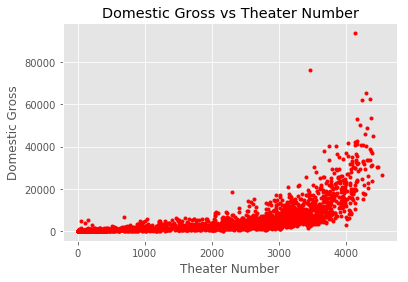

In [7]:
plt.plot(data['Theaters_Num'], data['DoGross_GT'], 'r.')
plt.title('Domestic Gross vs Theater Number')
plt.xlabel('Theater Number')
plt.ylabel('Domestic Gross')
plt.show()
plt.close()

After compare of many different features, we figure out those features are most important affect the box office. Therefore, we picked them and analyse their affect to the box office prediction. Figures above and below show that those features relationship with the domestic gross (domestic box office).

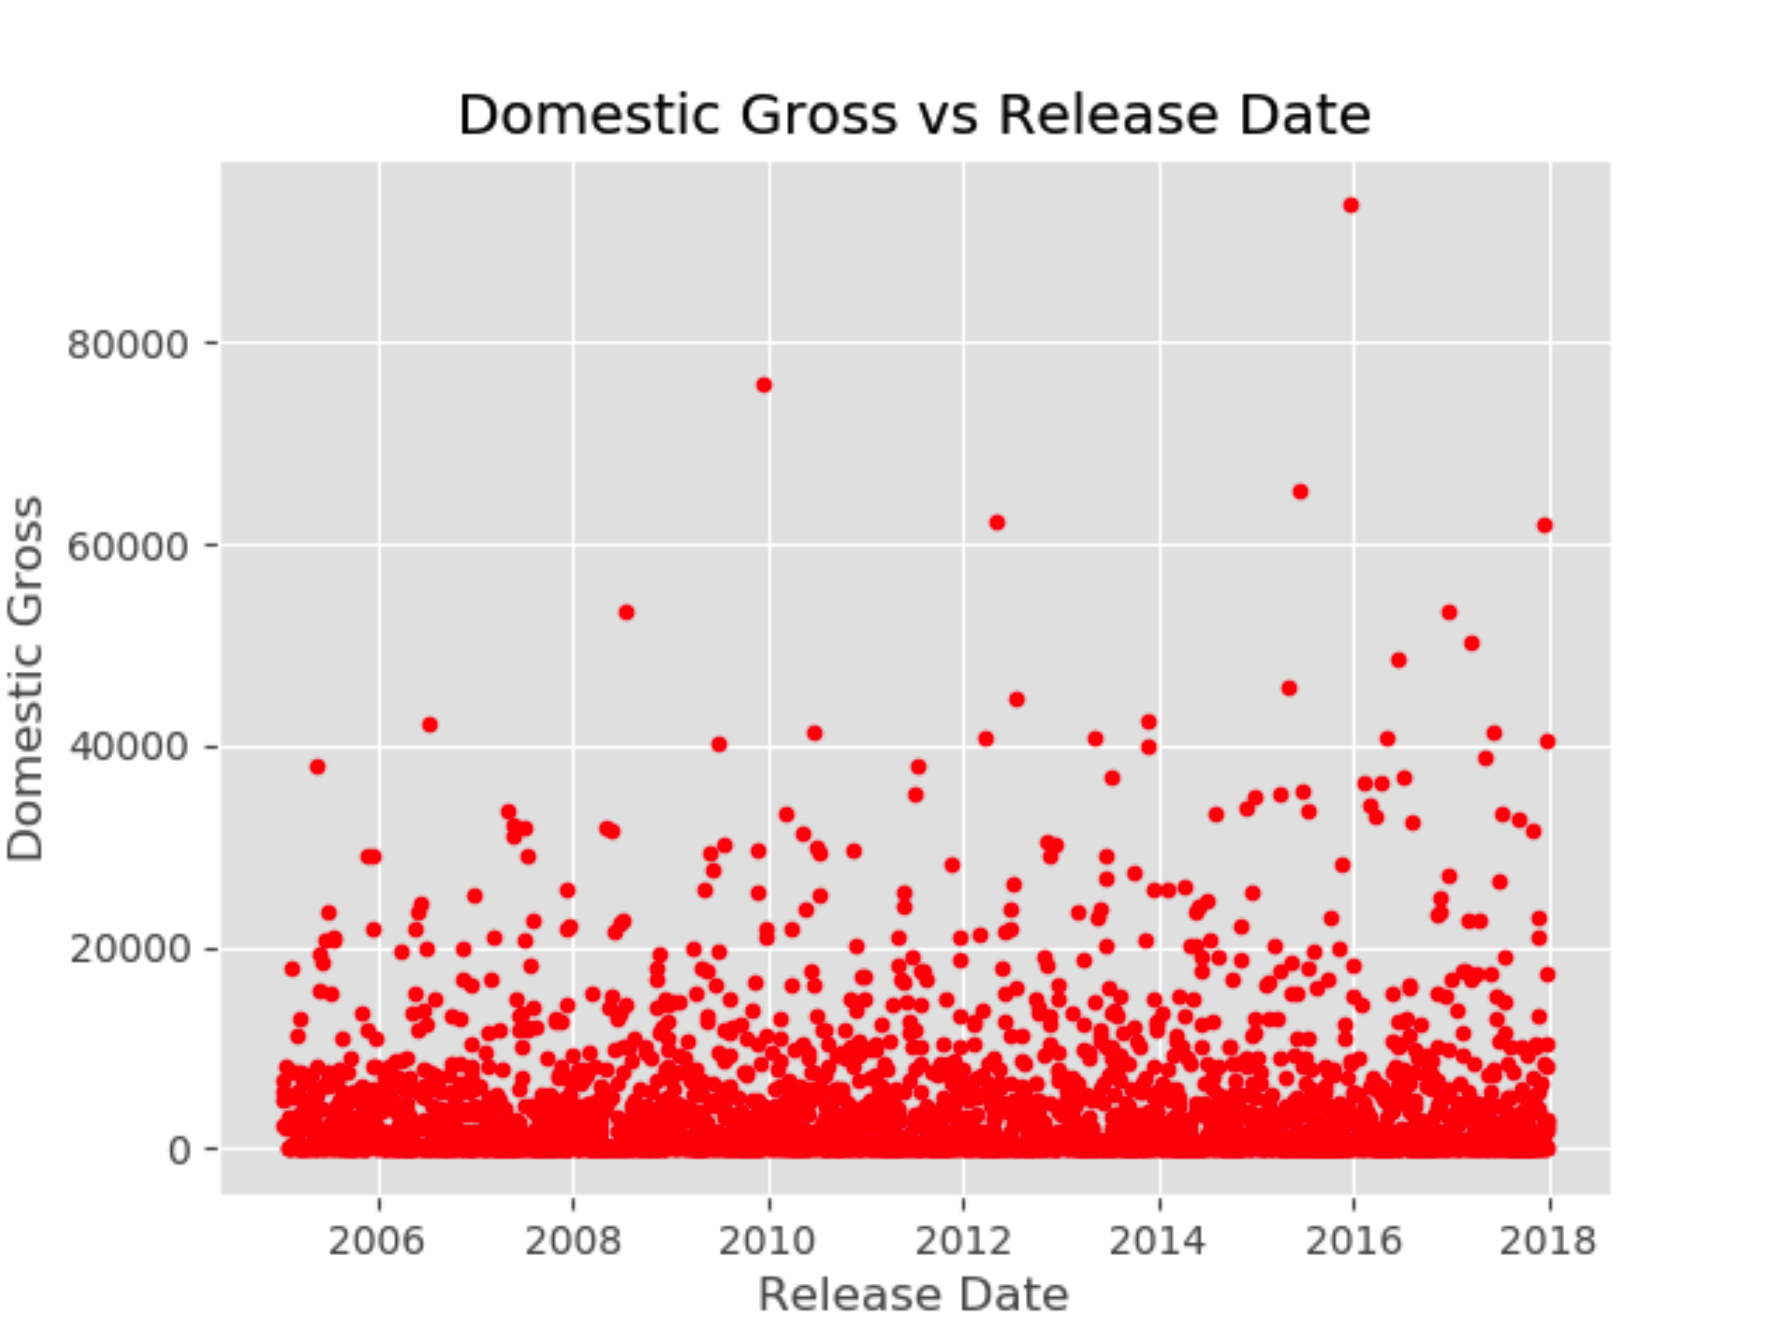

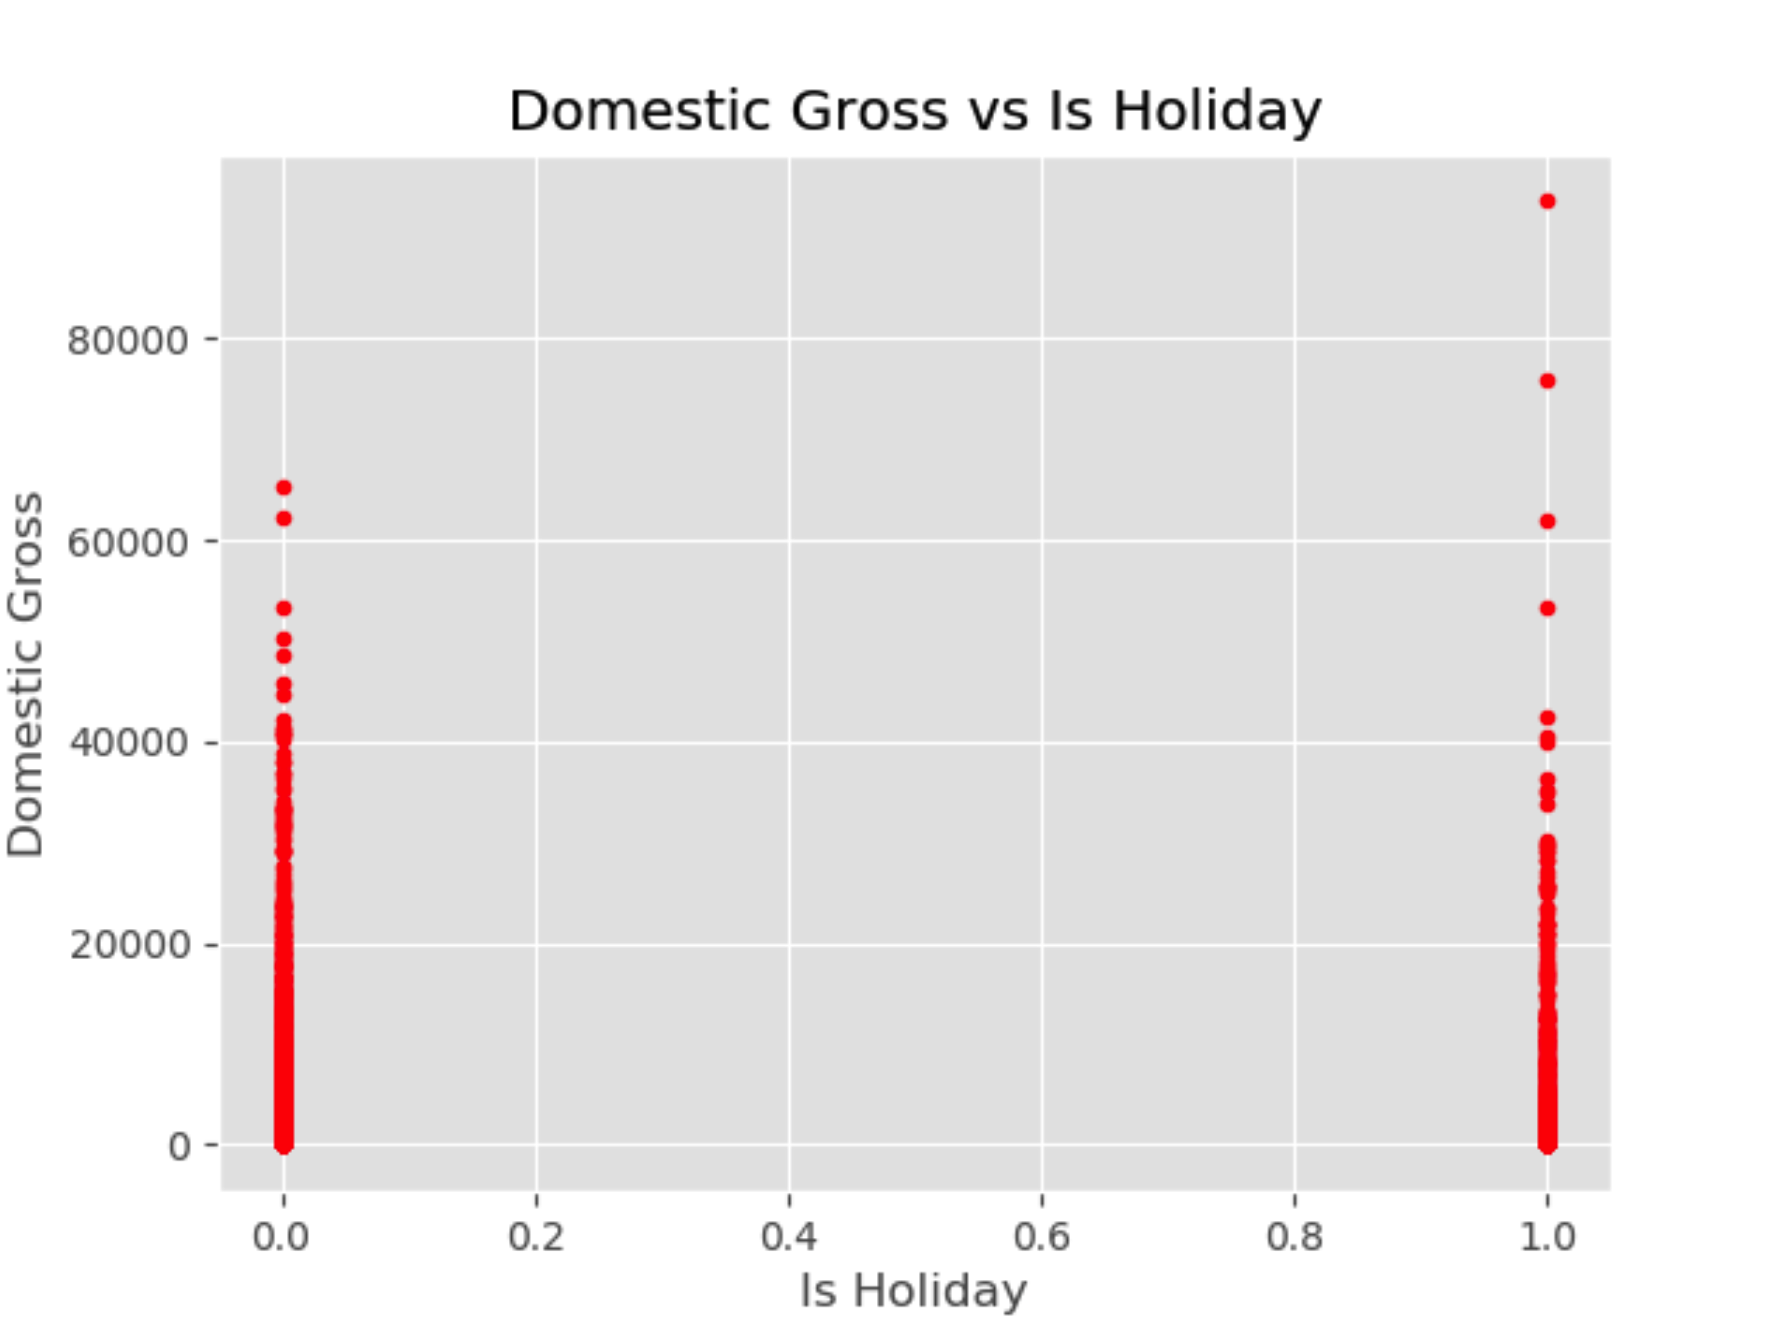

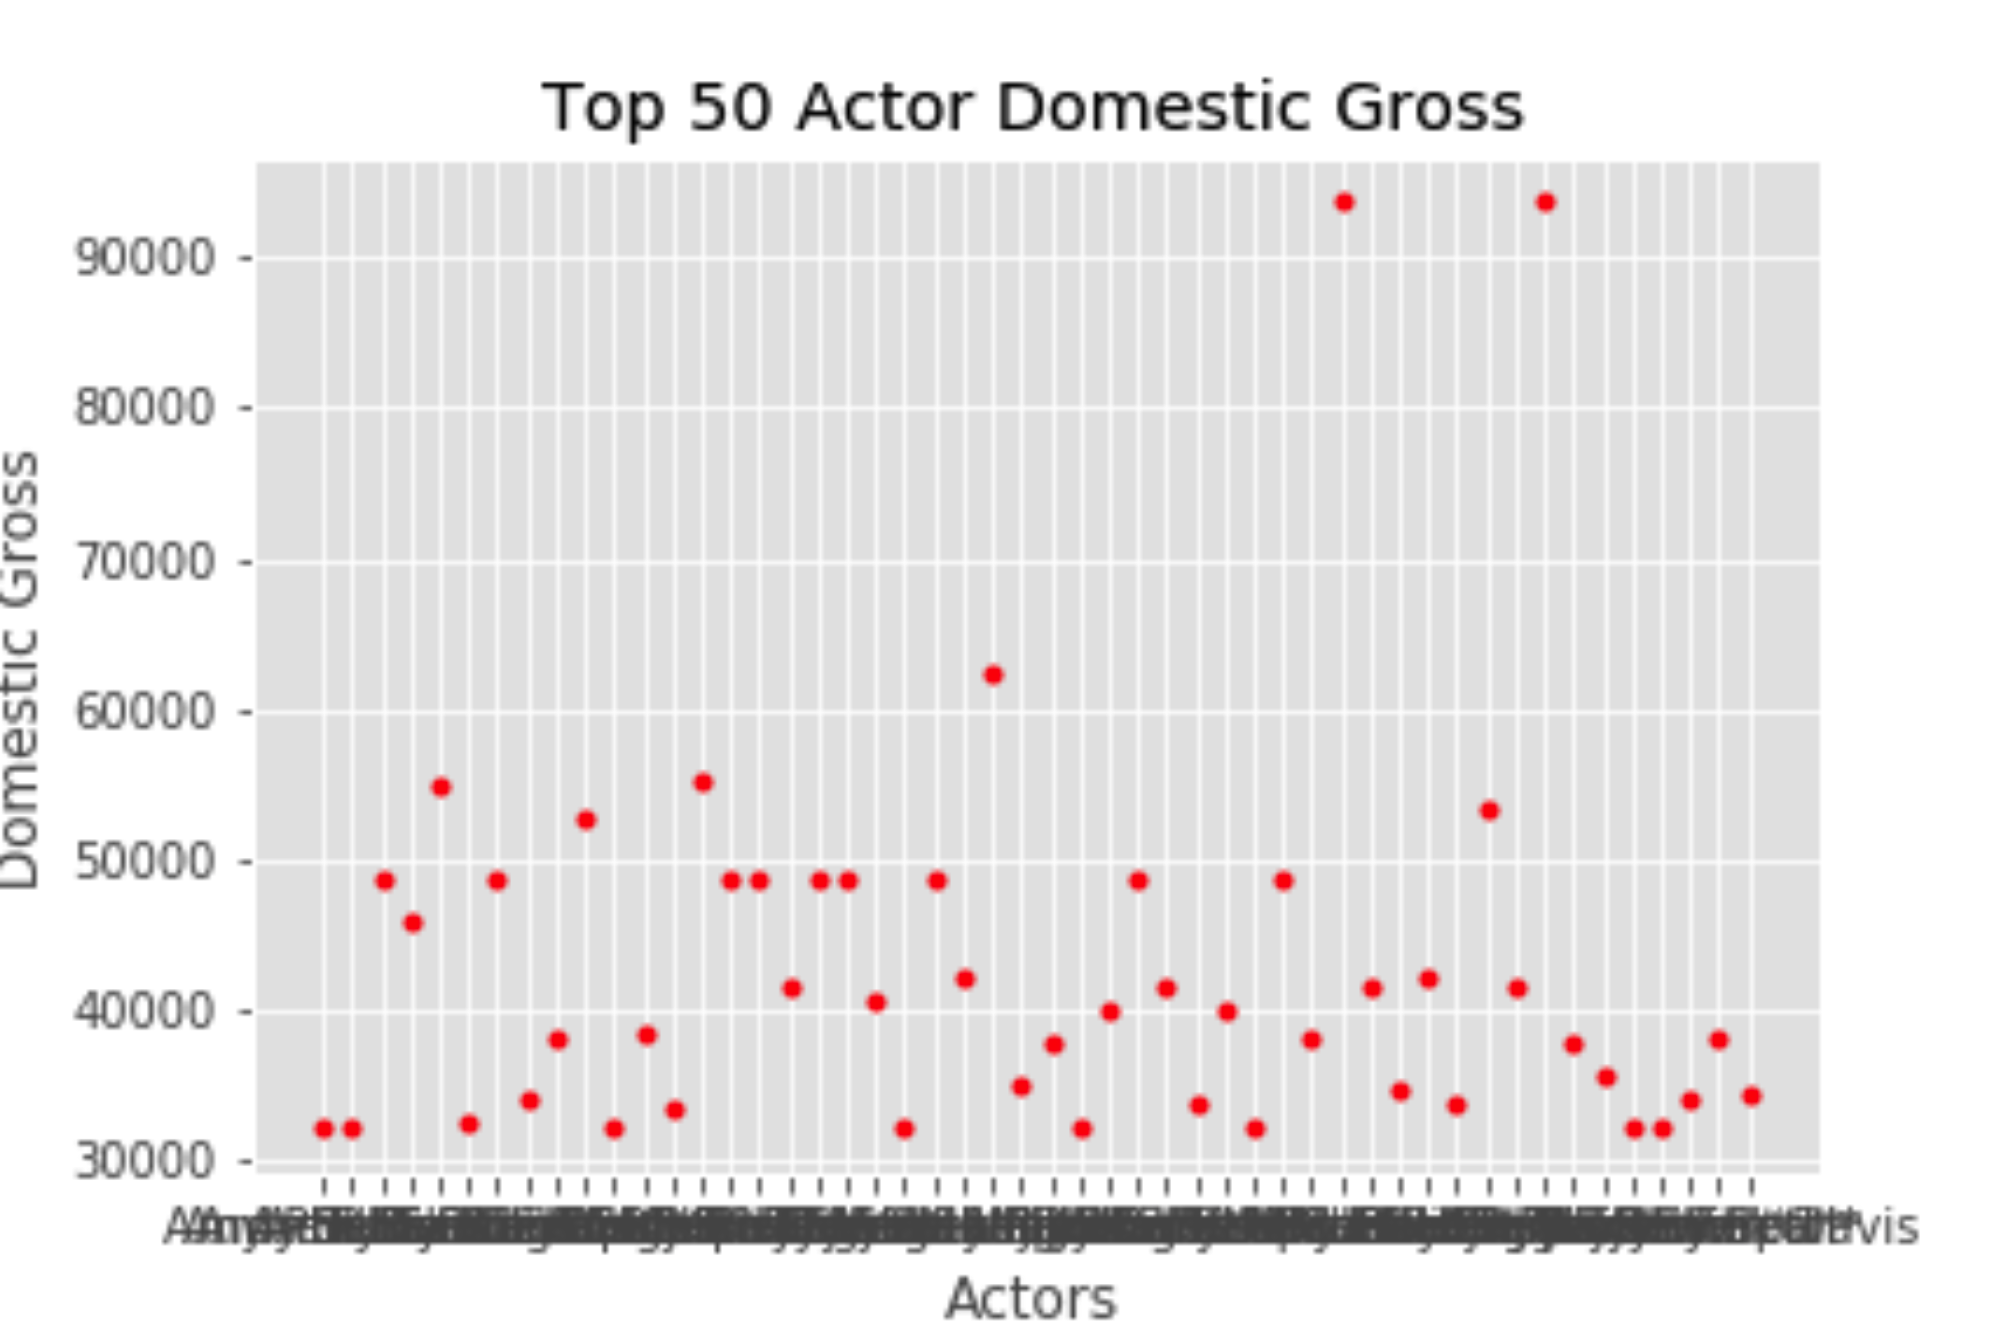

In [8]:
# Some figutes plot followed above codes 
from IPython.core.display import Image, display
display(Image('https://s3-us-west-2.amazonaws.com/pdsgroup/Releasedata.png', width=500, unconfined=True))
display(Image('https://s3-us-west-2.amazonaws.com/pdsgroup/holiday.png', width=500, unconfined=True))
display(Image('https://s3-us-west-2.amazonaws.com/pdsgroup/top50actors.png', width=500, unconfined=True))


We randomized the movie data and split into train and test data by 8:2

In [12]:
# randomly saperate train, test set as 8:2, index of Train_Movie_Names is value in P[:c]
data = data.reset_index()
P = np.random.permutation(len(data))
c = math.floor(len(data)*0.8)

Train_Data = data.iloc[P[:c]]
Test_Data = data.iloc[P[c:]]

Train_Movie_Names = Train_Data['Movie_Name']
Test_Movie_Names = Test_Data['Movie_Name']

# data schema
Train_Data.dtypes

index                                int64
Movie_Name                          object
DoGross_GT                         float64
DoGross_Magnitude                    int64
Genre_Action                         int64
Genre_Adventure                      int64
Genre_Animation                      int64
Genre_Comedy                         int64
Genre_Concert                        int64
Genre_Crime                          int64
Genre_Documentary                    int64
Genre_Drama                          int64
Genre_Epic                           int64
Genre_Family                         int64
Genre_Fantasy                        int64
Genre_Foreign                        int64
Genre_Historical                     int64
Genre_Horror                         int64
Genre_IMAX                           int64
Genre_Music                          int64
Genre_Period                         int64
Genre_Romance                        int64
Genre_Sci-Fi                         int64
Genre_Sport

Remove unneeded features

In [13]:
# drop useless feature
def dropfeatures(Train_Data):
    Train_Data = Train_Data.drop(['DoGross_Magnitude'], axis=1)
    Train_Data = Train_Data.drop(['Movie_Name'], axis=1)
    Train_Data = Train_Data.drop(['In_Release'], axis=1)
    Train_Data = Train_Data.drop(['Worldwide_Gross'], axis=1)
    Train_Data = Train_Data.drop(['Runtime_minnutes'], axis=1)
    return Train_Data

# domestic ground truth recale to 1000,000, 
def dropexamples(Train_Data):
    # Train_Data = Train_Data[Train_Data.DoGross_GT>=10]
    Train_Data['DoGross_GT'] = Train_Data['DoGross_GT']/100
    # print(Train_Data['DoGross_GT'][:10])
    return Train_Data

Train_Data = dropfeatures(Train_Data).fillna(value=0)
Test_Data = dropfeatures(Test_Data).fillna(value=0)
Train_Data = dropexamples(Train_Data)
Test_Data = dropexamples(Test_Data)

print('Number of train data', len(Train_Data))
print('Number of test data', len(Test_Data))

Number of train data 3084
Number of test data 771


Normalization functions that weren't used in the end

In [14]:
def normalizatin_Parameter(train, col_key):
    a = np.array(train[col_key])
    return np.min(a), np.max(a)

def make_normalization(Min, Max, data, col_key):
    b = (np.array(data[col_key])-Min)/(Max-Min)
    b = b + 0.01*(b == 0)
    b = 100*b
    data['O' + col_key] = pd.Series(b, index = data.index)
    data = data.drop([col_key], axis=1)
    return data

# make normalization of production budget
# Min, Max = normalizatin_Parameter(Train_Data, 'Product_Budget')
# Train_Data = make_normalization(Min, Max, Train_Data, 'Product_Budget')
# Test_data = make_normalization(Min, Max, Test_data, 'Product_Budget')
# Min, Max = normalizatin_Parameter(Train_Data, 'Runtime_minnutes')
# Train_Data = make_normalization(Min, Max, Train_Data, 'Runtime_minnutes')
# Test_data = make_normalization(Min, Max, Test_data, 'Runtime_minnutes')

Generate features and labels for train and test data

In [15]:
#get trainX trainY, testX, testY
Train_y = np.array(Train_Data['DoGross_GT'])
Test_y = np.array(Test_Data['DoGross_GT'])
Train_X = np.array(Train_Data.drop(['DoGross_GT'], axis = 1))
Test_X = np.array(Test_Data.drop(['DoGross_GT'], axis = 1))

print(Train_X.shape, Train_y.shape, Test_X.shape, Test_y.shape)

(3084, 284) (3084,) (771, 284) (771,)


Train models using Linear Regression and Decision Tree Regression

In [16]:
lrfull = linear_model.LinearRegression()
lrfull = lrfull.fit(Train_X, Train_y, np.random.random(Train_X.shape[0]))

clf = tree.DecisionTreeRegressor()
clf = clf.fit(Train_X, Train_y, np.random.random(Train_X.shape[0]))

## Validation
Linear Regression predicted negative box office which doesn't make sense
This could be due its higher sensitivity to data fluctuation

In [17]:
def predict_error(lr, X, y):
    p_y = lr.predict(X)
    print('Number of negative labels', np.sum((y<0).astype(int)))
    print('Number of negative predictions', np.sum((p_y<0).astype(int)))
#     p_y = p_y*(p_y>=0) - p_y*(p_y<0)
    e = p_y - y
    error = (p_y - y)**2
    print(np.sum((error<1).astype(int)), 'error < 1')
    print(np.sum((error>100).astype(int)), 'error > 100')
#     error = error*(error<1)
    print('Maximum error', np.amax(error))
    maximum_error_index = np.argmax(error)
    print('Maximum error index', maximum_error_index, 'Prediction', p_y[maximum_error_index], 'Expected', y[maximum_error_index])
    return p_y, np.sum((error**2))/len(error), error

print('Linear Regression')
p_y_lr, average_squared_error, errors_lr = predict_error(lrfull, Test_X, Test_y)
print('Test set size', len(p_y_lr))
print('Average squared error', average_squared_error)

print('Decision Tree Regression')
p_y_clr, average_squared_error, errors_clf = predict_error(clf, Test_X, Test_y)
print('Test set size', len(p_y_clr))
print('Average squared error', average_squared_error)

Linear Regression
Number of negative labels 0
Number of negative predictions 266
54 error < 1
331 error > 100
Maximum error 91010.7869925
Maximum error index 493 Prediction 110.883466684 Expected 412.563408
Test set size 771
Average squared error 50226254.0106
Decision Tree Regression
Number of negative labels 0
Number of negative predictions 0
326 error < 1
254 error > 100
Maximum error 149053.676297
Maximum error index 624 Prediction 237.283207 Expected 623.35791
Test set size 771
Average squared error 55987029.6099


Linear Regression vs Decision Tree Regression

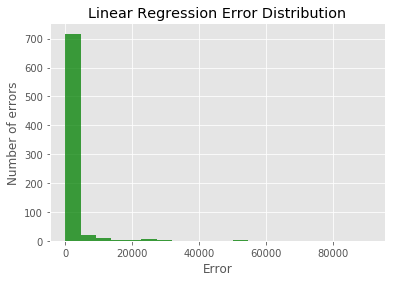

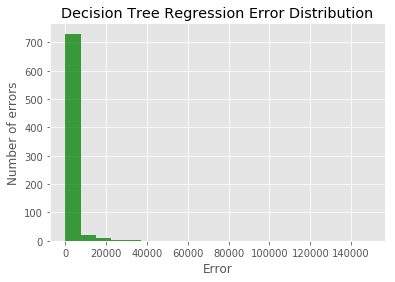

In [18]:
plt.title('Linear Regression Error Distribution')
plt.xlabel('Error')
plt.ylabel('Number of errors')
plt.hist(errors_lr, 20, facecolor='g', alpha=0.75)
plt.show()
plt.close()

plt.title('Decision Tree Regression Error Distribution')
plt.xlabel('Error')
plt.ylabel('Number of errors')
plt.hist(errors_clf, 20, facecolor='g', alpha=0.75)
plt.show()
plt.close()

Close-up view which reveals more obviously that the accuracy of Linear Regression is worse than Decision Tree Regression, where Decision Tree Regression skews more towards that left.

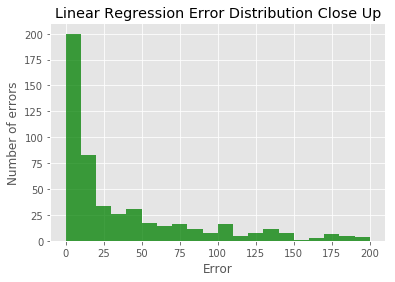

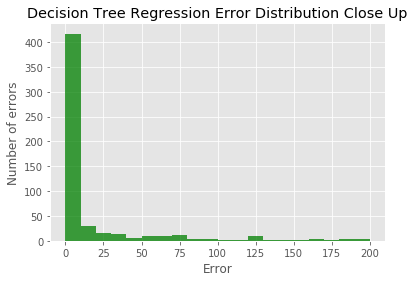

In [19]:
plt.title('Linear Regression Error Distribution Close Up')
plt.xlabel('Error')
plt.ylabel('Number of errors')
plt.hist(errors_lr, 20, facecolor='g', alpha=0.75, range=(0, 200))
plt.show()
plt.close()

plt.title('Decision Tree Regression Error Distribution Close Up')
plt.xlabel('Error')
plt.ylabel('Number of errors')
plt.hist(errors_clf, 20, facecolor='g', alpha=0.75, range=(0, 200))
plt.show()
plt.close()

# Part 4 Conclusion

## about page parsing
During the page parsing, we actually try to use several different ways to collect data. At first we uses Beautifulsoup and regex to get movie information, which works fine at first. However not all movie webpages on mojoboxoffice.com has the same structure. This could be a problem when you are trying to wirte a page parsing pipeline which works on thousands of webpage.

Then there is a pretty good tool for page parsing, which is lxml and xpath. This is especially convient when it combines with the developer tool of Chrome. 

## about data processing
Most information about movie is non numberical data. So we have to find several ways to convert those data into meaningful number. There are several common ways which are covered in 15688 lecture. We have several tries to accomplish that.

About the time data, one processing method covered in 15688 lecture is convert them into sine and cosine data. However time data in our project is about the when the movie is released and avaliable on theaters. Naturally we think how could this affect the gross is whether it is releaed before holiday.

So we convert the Release Date, Close Date, and In_Release into one single bool data, which is whether this movie is on theater during holiday.

Also we try to use one-hot encoding to convert people information about a movie. One main problem here is that all the movies might have thousands of different actors, directors and writters, which would make our feature too large. So in our project we try to find the relationship of actors and their mean gross of movie. This lead us to a conclusion that comparing to full actor data, the movie gross mainly depends on those top actors. So we select top 50 actors as our actor one-hot encoding data. Same method is using in other people information.